<a href="https://colab.research.google.com/github/jindalankush28/attendence/blob/master/plant_pathology_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Initializing the TPU system: grpc://10.3.118.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.118.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/plantpath/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
df_train = pd.read_csv('/content/gdrive/My Drive/plant-pathology-2020-fgvc7/train.csv')
df_train.head()
labels = ['healthy','multiple_diseases','rust','scab']
print(df_train.head())

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


In [5]:
TRAINING_DIR = "/content/gdrive/My Drive/plant-pathology-2020-fgvc7/train"
train_datagen = ImageDataGenerator(rescale=1/255,
                                   samplewise_center=True,
        samplewise_std_normalization= True,
        horizontal_flip=True, vertical_flip=True,shear_range=0.2, zoom_range=0.2,
        rotation_range=20)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    
                                                    class_mode='categorical',
                                                    target_size=(100,100))

VALIDATION_DIR = "/content/gdrive/My Drive/plant-pathology-2020-fgvc7/cv"
validation_datagen = ImageDataGenerator(rescale=1/255,
                                        samplewise_center=True,
        samplewise_std_normalization= True,
        horizontal_flip=True, vertical_flip=True,shear_range=0.2, zoom_range=0.2,
        rotation_range=20)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                  batch_size=20,
                                                  
                                                  class_mode='categorical',
                                                  target_size=(100,100))
                                         

Found 1454 images belonging to 4 classes.
Found 367 images belonging to 4 classes.


In [6]:
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC()])

29089792/29084464 [==============================] - 1s 0us/step


Epoch 1/3
100/100 [==============================] - 607s 6s/step - loss: 0.8507 - auc: 0.8131 - val_loss: 5.4161 - val_auc: 0.8049
Epoch 2/3
100/100 [==============================] - 101s 1s/step - loss: 0.6887 - auc: 0.7912 - val_loss: 4.1749 - val_auc: 0.8090
Epoch 3/3
100/100 [==============================] - 102s 1s/step - loss: 0.5483 - auc: 0.8222 - val_loss: 0.8509 - val_auc: 0.8388


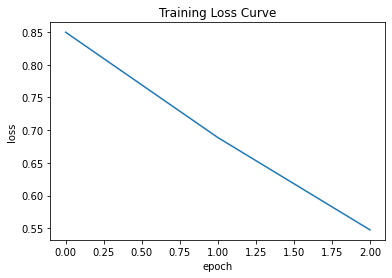

In [7]:
history = model.fit_generator(train_generator, 
                              validation_data=validation_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()


In [8]:
sub = pd.read_csv('/content/gdrive/My Drive/plant-pathology-2020-fgvc7/sample_submission.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/plant-pathology-2020-fgvc7/test.csv')
test_data.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [9]:
def format_path(st):
    return '/content/gdrive/My Drive/plant-pathology-2020-fgvc7/test/' + st + '.jpg'
test_paths = test_data.image_id.apply(format_path).values
print(test_paths.shape)

(1821,)


In [0]:
def decode_image(filename, label=None, image_size=(100,100)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [0]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)


In [12]:
probs = model.predict(test_dataset, verbose=1)

AttributeError: ignored

In [16]:
test_DIR = "/content/gdrive/My Drive/plant-pathology-2020-fgvc7/test"
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_DIR,
                                                  batch_size=20,
                                                  
                                                  target_size=(100,100))
                                         

Found 0 images belonging to 0 classes.


In [14]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(100,100))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(classes)

Saving Test_0.jpg to Test_0 (1).jpg
[[0. 0. 1. 0.]]


In [15]:

sub.loc[:, 'healthy':] = classes
sub.to_csv('submission.csv', index=False)
sub.head()

ValueError: ignored